# Mihir Thakar

# Dataset: 
# The Bay Area Travel Survey (BATS) 2000 
 
# The Bay Area Travel Survey is a large-scale regional household travel survey conducted in the nine county San Francisco Bay Area of California. The Metropolitan Transportation Commission (MTC) has periodically sponsored BATS to provide data to support travel modeling and analysis of regional travel behavior. The target data collection period for BATS 2000 was of course the 2000 calendar year. The survey consisted of an activity-based travel diary that requested information on all in-home and out-of- home activities over a two-day period, including weekday and weekend pursuits. In all, more than 15,000 households participated in the survey. 
 
# Examine travel mode choice for morning commute by a sample of 10,000 Bay Area residents. The choice set for any individual consists of a maximum of six travel alternatives: drive-alone, shared ride, walk, bike, walk to transit and drive to transit. The variables in the dataset are enumerated in Table 1.

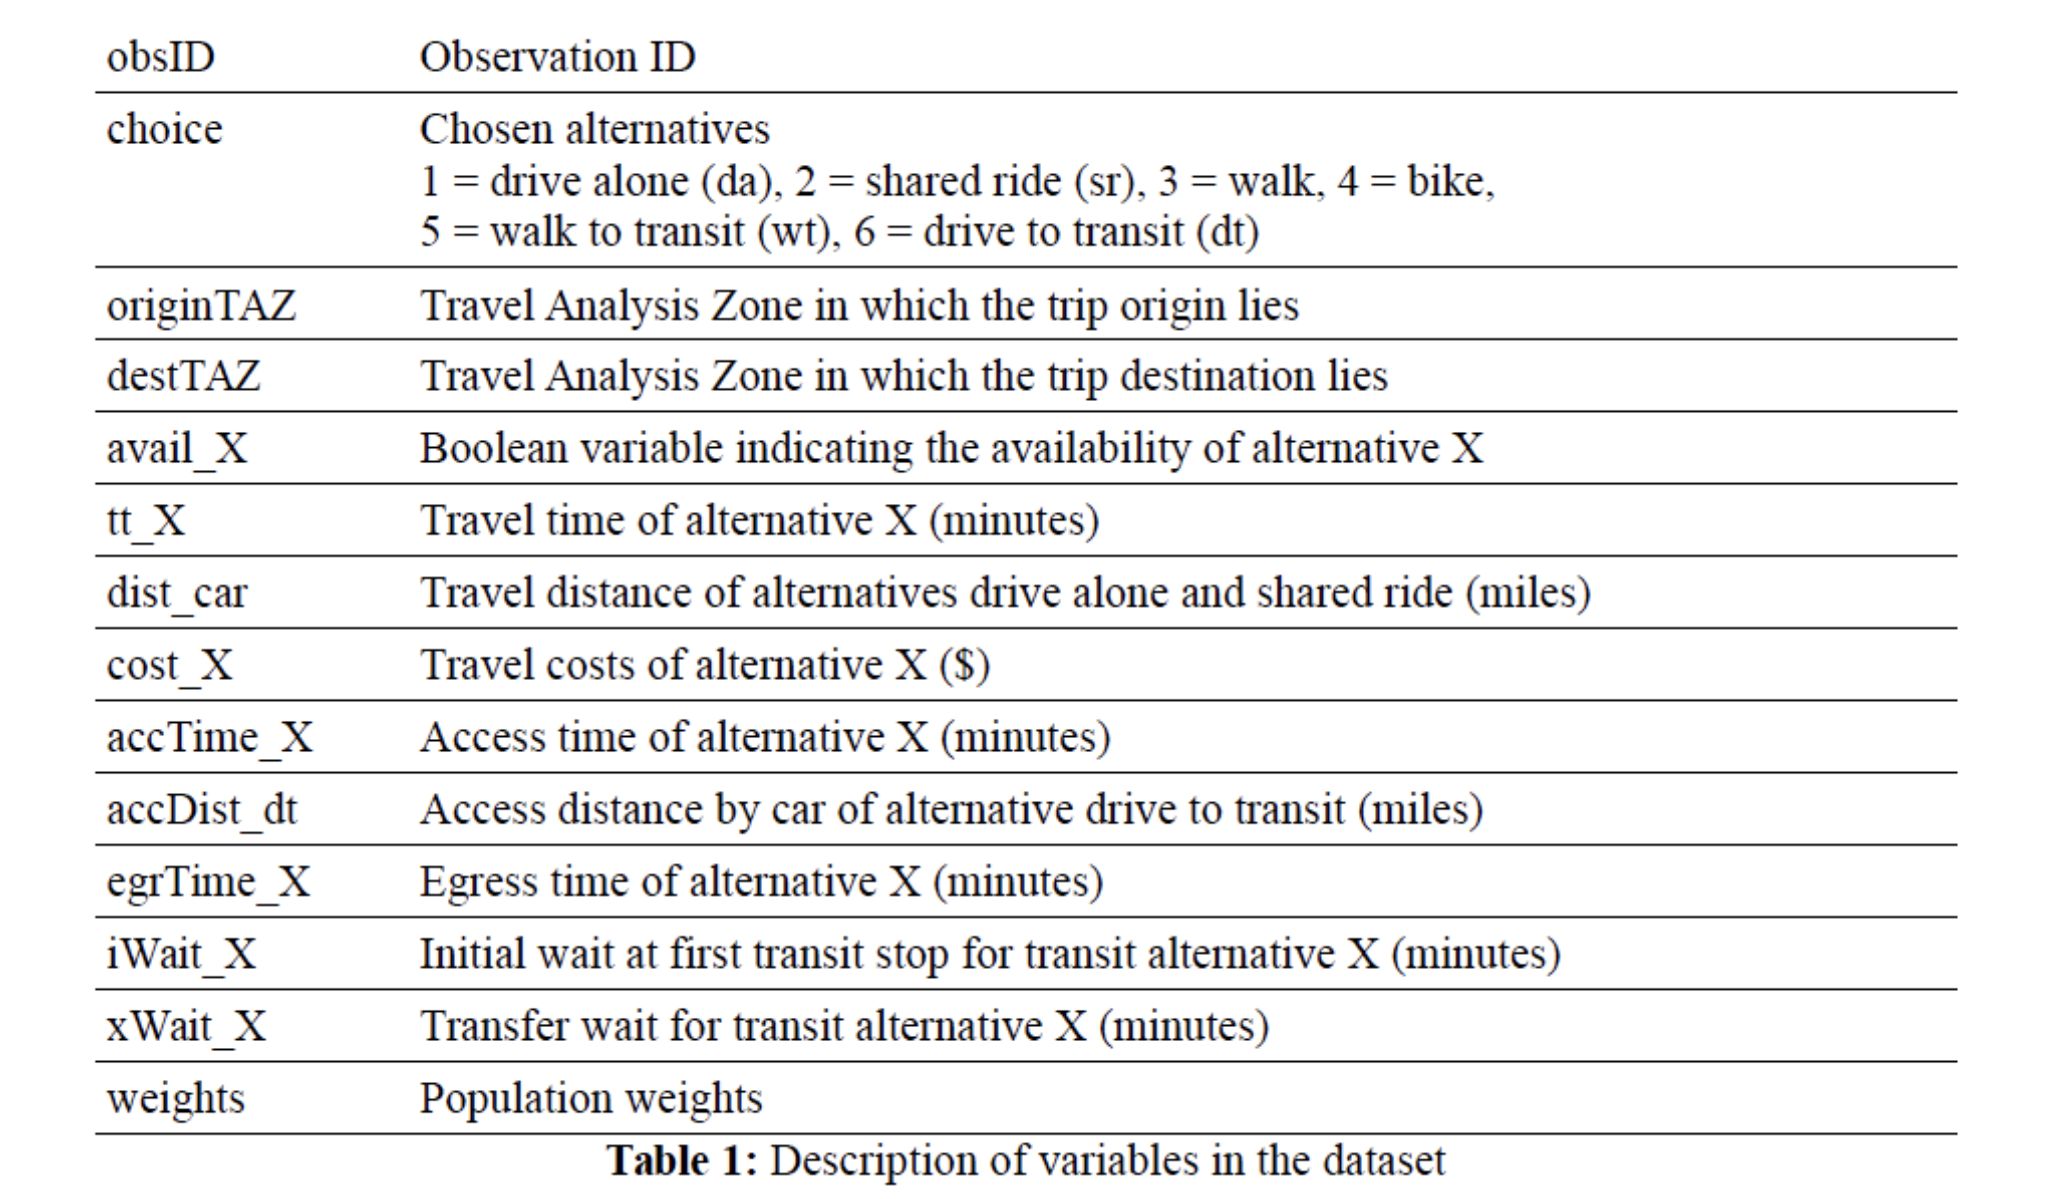

In [1]:

# importing the requried libraries
from collections import OrderedDict    # For recording the model specification 

import pandas as pd                    # For file input/output
import numpy as np                     # For vectorized math operations

import pylogit as pl                   # For MNL model estimation and
                                       # conversion from wide to long format

# reading the data file 
data_wide  = pd.read_csv("data01.csv",sep=",")

In [2]:
data_wide

,originTAZ,destTAZ,tt_da,cost_da,tt_sr,cost_sr,tt_walk,tt_bike,tt_wt,accTime_wt,...,dist_car,accDist_dt,avail_da,avail_sr,avail_walk,avail_bike,avail_wt,avail_dt,choice,obsID
0,1308,1300,33.85,1.97650,33.85,0.98824,216.87,37.35,0.000,0.0,...,11.20,0.00,1,1,0,0,0,0,1,1
1,1269,1284,31.71,2.53060,31.71,1.26530,277.59,47.81,0.000,0.0,...,14.34,14.32,1,1,0,1,0,1,2,2
2,342,429,70.77,6.80650,70.77,3.40320,615.72,106.04,71.700,21.6,...,38.57,16.40,1,1,0,0,0,1,1,3
3,627,583,31.48,2.69290,31.48,1.34650,249.60,42.99,70.435,20.2,...,15.26,12.77,1,1,0,1,1,1,2,4
4,1296,1310,40.02,3.70060,40.02,1.85030,395.21,68.06,0.000,0.0,...,20.97,0.00,1,1,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26696,103,125,29.11,0.80471,29.11,0.40235,87.27,15.03,20.930,23.0,...,4.56,11.43,1,1,1,0,1,1,5,26697
26697,103,125,29.11,0.80471,29.11,0.40235,87.27,15.03,20.930,23.0,...,4.56,11.43,1,1,1,0,1,1,5,26698
26698,34,971,95.19,5.46410,95.19,2.73210,406.65,70.03,48.975,12.6,...,22.01,19.83,1,1,0,0,1,1,5,26699
26699,129,26,60.38,1.81940,60.38,0.90971,166.52,28.68,41.475,12.0,...,10.31,9.85,1,1,0,0,1,1,5,26700


In [3]:
data_wide.columns

Index(['originTAZ', 'destTAZ', 'tt_da', 'cost_da', 'tt_sr', 'cost_sr',
       'tt_walk', 'tt_bike', 'tt_wt', 'accTime_wt', 'egrTime_wt', 'iWait_wt',
       'xWait_wt', 'cost_wt', 'tt_dt', 'accTime_dt', 'egrTime_dt', 'iWait_dt',
       'xWait_dt', 'cost_dt', 'weights', 'dist_car', 'accDist_dt', 'avail_da',
       'avail_sr', 'avail_walk', 'avail_bike', 'avail_wt', 'avail_dt',
       'choice', 'obsID'],
      dtype='object')

In [4]:
ind_variables = data_wide.columns.tolist()[:2] + ["weights"]
ind_variables

['originTAZ', 'destTAZ', 'weights']

In [5]:
# converting the data from wide to long format

# Create the list of individual specific variables
ind_variables = data_wide.columns.tolist()[:2] + ["weights"]

# Specify the variables that vary across individuals and some or all alternatives
# The keys are the column names that will be used in the long format dataframe.
# The values are dictionaries whose key-value pairs are the alternative id and
# the column name of the corresponding column that encodes that variable for
# the given alternative. Examples below.
alt_varying_variables = {u'travel_time': dict([(1, 'tt_da'),
                                               (2, 'tt_sr'),
                                               (3, 'tt_walk'),
                                               (4, 'tt_bike'),
                                               (5, 'tt_wt'),
                                               (6, 'tt_dt')]),
                          u'distance_car': dict([(1, 'dist_car'), #drive alone and shared drive
                                                (2, 'dist_car')]),
                          u'travel_cost': dict([(1, 'cost_da'),
                                                (2, 'cost_sr'),
                                                (5, 'cost_wt'),
                                                (6, 'cost_dt')]),
                          u'access_time': dict([(5, 'accTime_wt'), #walk transit drive transit time to get there
                                                (6, 'accTime_dt')]),
                          u'egress_time': dict([(5, 'egrTime_wt'), # time of alighting time of boarding 
                                                (6, 'egrTime_dt')]),
                          u'initial_wait': dict([(5, 'iWait_wt'), #wait time at first stop
                                                 (6, 'iWait_dt')]),
                          u'transfer_wait': dict([(5, 'xWait_wt'), #transfer wait time 
                                                  (6, 'xWait_dt')]),
                          u'access_distance_dt': dict([(6, "accDist_dt")])}

# Specify the availability variables
# Note that the keys of the dictionary are the alternative id's.
# The values are the columns denoting the availability for the
# given mode in the dataset.


availability_variables = {1: 'avail_da',
                          2: 'avail_sr', 
                          3: 'avail_walk',
                          4: 'avail_bike',
                          5: 'avail_wt', 
                          6: 'avail_dt'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id" #what mode choice is avaialble to that person in particular 

# Create a custom id column that ignores the fact that this is a 
# panel/repeated-observations dataset. Note the +1 ensures the id's start at one.
obs_id_column = "obsID" # the identifier for the person, number of rows repreresent how many choices they have available (obsid1 has drive alone and shared ride only)

# Create a variable recording the choice column
choice_column = "choice" #ultimately 1 or 0 whether they chose that alternative (mode) (person 2 chose shared ride)

In [6]:
# Perform the conversion to long-format
data_long = pl.convert_wide_to_long(data_wide, 
                                           ind_variables, 
                                           alt_varying_variables, 
                                           availability_variables, 
                                           obs_id_column, 
                                           choice_column,
                                           new_alt_id_name=custom_alt_id)
# Look at the resulting long-format dataframe
data_long.head(10)

,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,egress_time,initial_wait,transfer_wait,access_distance_dt
0,1,1,1,1308,1300,21.0,33.850,11.20,1.97650,0.00,0.00,0.0,0.00,0.00
1,1,2,0,1308,1300,21.0,33.850,11.20,0.98824,0.00,0.00,0.0,0.00,0.00
2,2,1,0,1269,1284,51.5,31.710,14.34,2.53060,0.00,0.00,0.0,0.00,0.00
3,2,2,1,1269,1284,51.5,31.710,14.34,1.26530,0.00,0.00,0.0,0.00,0.00
4,2,4,0,1269,1284,51.5,47.810,0.00,0.00000,0.00,0.00,0.0,0.00,0.00
5,2,6,0,1269,1284,51.5,16.705,0.00,4.24000,22.05,26.35,24.0,33.75,14.32
6,3,1,1,342,429,37.0,70.770,38.57,6.80650,0.00,0.00,0.0,0.00,0.00
7,3,2,0,342,429,37.0,70.770,38.57,3.40320,0.00,0.00,0.0,0.00,0.00
8,3,6,0,342,429,37.0,86.355,0.00,6.01000,13.78,39.62,24.0,21.25,16.40
9,4,1,0,627,583,137.0,31.480,15.26,2.69290,0.00,0.00,0.0,0.00,0.00


In [7]:
data_long

,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,egress_time,initial_wait,transfer_wait,access_distance_dt
0,1,1,1,1308,1300,21.0,33.850,11.20,1.97650,0.00,0.00,0.00,0.00,0.00
1,1,2,0,1308,1300,21.0,33.850,11.20,0.98824,0.00,0.00,0.00,0.00,0.00
2,2,1,0,1269,1284,51.5,31.710,14.34,2.53060,0.00,0.00,0.00,0.00,0.00
3,2,2,1,1269,1284,51.5,31.710,14.34,1.26530,0.00,0.00,0.00,0.00,0.00
4,2,4,0,1269,1284,51.5,47.810,0.00,0.00000,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102390,26700,6,0,129,26,43.5,35.600,0.00,3.26000,22.42,22.56,5.21,0.00,9.85
102391,26701,1,0,129,26,43.5,60.380,10.31,1.81940,0.00,0.00,0.00,0.00,0.00
102392,26701,2,0,129,26,43.5,60.380,10.31,0.90971,0.00,0.00,0.00,0.00,0.00
102393,26701,5,1,129,26,43.5,41.475,0.00,3.32000,12.00,16.70,11.33,11.88,0.00


In [8]:
data_long['choice'].dtype

dtype('int32')

In [9]:
#a = data_long.loc[data_long['mode_id'] == 1]
#a 
#Testing code to see how to filter by modeID

In [10]:
#b = a.loc[data_long['choice'] == 1]
#b
#Testing code to see how to filter by choice

In [11]:
DFLIST = []
i = 1
while i < 7:
    df1 = data_long.loc[data_long['mode_id'] == i]
    df2 = df1.loc[df1['choice'] == 1]
    fin = df2
    DFLIST.append(fin)
    i+=1
DFLIST[0]
#The following is a list of dataframes for each mode_id 
#For each frame the mode_id represents all the individuals that choose that alternative
#Hence the 6 frames are populated from 1-6 
#Choice column is binary [1,0] and value of 1 representing that was the transportation mode_id taken

##Example below is for drive alone alternative

,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,egress_time,initial_wait,transfer_wait,access_distance_dt
0,1,1,1,1308,1300,21.0,33.85,11.20,1.9765,0.0,0.0,0.0,0.0,0.0
6,3,1,1,342,429,37.0,70.77,38.57,6.8065,0.0,0.0,0.0,0.0,0.0
14,5,1,1,1296,1310,46.0,40.02,20.97,3.7006,0.0,0.0,0.0,0.0,0.0
16,6,1,1,1296,1310,46.0,40.02,20.97,3.7006,0.0,0.0,0.0,0.0,0.0
18,7,1,1,1296,1295,46.0,22.19,5.92,1.0447,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102231,26662,1,1,94,1,29.0,54.25,7.98,1.4082,0.0,0.0,0.0,0.0,0.0
102298,26678,1,1,114,1136,38.5,144.05,55.95,11.4540,0.0,0.0,0.0,0.0,0.0
102307,26680,1,1,114,2,38.5,41.63,6.37,1.1241,0.0,0.0,0.0,0.0,0.0
102352,26691,1,1,115,485,17.0,117.29,93.03,16.4170,0.0,0.0,0.0,0.0,0.0


In [12]:
for a in DFLIST:
    display(a) #Displays all the alternatives and their corresponding dataframes

,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,egress_time,initial_wait,transfer_wait,access_distance_dt
0,1,1,1,1308,1300,21.0,33.85,11.20,1.9765,0.0,0.0,0.0,0.0,0.0
6,3,1,1,342,429,37.0,70.77,38.57,6.8065,0.0,0.0,0.0,0.0,0.0
14,5,1,1,1296,1310,46.0,40.02,20.97,3.7006,0.0,0.0,0.0,0.0,0.0
16,6,1,1,1296,1310,46.0,40.02,20.97,3.7006,0.0,0.0,0.0,0.0,0.0
18,7,1,1,1296,1295,46.0,22.19,5.92,1.0447,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102231,26662,1,1,94,1,29.0,54.25,7.98,1.4082,0.0,0.0,0.0,0.0,0.0
102298,26678,1,1,114,1136,38.5,144.05,55.95,11.4540,0.0,0.0,0.0,0.0,0.0
102307,26680,1,1,114,2,38.5,41.63,6.37,1.1241,0.0,0.0,0.0,0.0,0.0
102352,26691,1,1,115,485,17.0,117.29,93.03,16.4170,0.0,0.0,0.0,0.0,0.0


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,egress_time,initial_wait,transfer_wait,access_distance_dt
3,2,2,1,1269,1284,51.5,31.71,14.34,1.26530,0.0,0.0,0.0,0.0,0.0
10,4,2,1,627,583,137.0,31.48,15.26,1.34650,0.0,0.0,0.0,0.0,0.0
37,13,2,1,1362,1335,217.0,98.63,39.22,3.46060,0.0,0.0,0.0,0.0,0.0
41,14,2,1,648,661,116.0,51.60,17.55,1.54850,0.0,0.0,0.0,0.0,0.0
44,15,2,1,1029,970,34.5,52.65,12.91,1.13910,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102107,26632,2,1,845,991,68.5,80.93,40.98,2.41060,0.0,0.0,0.0,0.0,0.0
102155,26645,2,1,72,199,115.0,67.32,21.83,1.92620,0.0,0.0,0.0,0.0,0.0
102160,26646,2,1,133,106,55.0,40.00,7.33,0.64676,0.0,0.0,0.0,0.0,0.0
102166,26647,2,1,133,106,55.0,40.00,7.33,0.64676,0.0,0.0,0.0,0.0,0.0


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,egress_time,initial_wait,transfer_wait,access_distance_dt
484,136,3,1,34,5,218.0,59.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1787,500,3,1,991,991,100.5,20.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1795,502,3,1,991,991,100.5,20.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1927,537,3,1,356,356,37.5,21.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2152,596,3,1,341,341,59.0,19.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102242,26664,3,1,22,24,408.0,9.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102269,26670,3,1,7,16,82.5,42.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102272,26671,3,1,7,16,82.5,42.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102345,26689,3,1,30,10,98.5,23.82,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,egress_time,initial_wait,transfer_wait,access_distance_dt
316,89,4,1,1242,1222,109.0,27.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1090,296,4,1,340,355,72.0,13.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1169,320,4,1,705,709,164.0,21.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1582,438,4,1,356,340,135.0,12.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1588,439,4,1,356,355,135.0,12.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101491,26498,4,1,102,52,50.0,28.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101494,26499,4,1,102,59,50.0,31.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101497,26500,4,1,102,59,50.0,31.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101535,26508,4,1,137,137,122.5,4.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,egress_time,initial_wait,transfer_wait,access_distance_dt
147,39,5,1,137,17,45.5,32.670,0.0,2.49,27.8,22.6,6.00,5.00,0.0
149,40,5,1,137,17,45.5,32.670,0.0,2.49,27.8,22.6,6.00,5.00,0.0
152,41,5,1,137,147,45.5,30.515,0.0,1.66,10.6,10.5,16.25,0.00,0.0
155,42,5,1,137,147,45.5,30.515,0.0,1.66,10.6,10.5,16.25,0.00,0.0
250,69,5,1,1058,16,60.5,72.800,0.0,4.74,25.0,25.2,15.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102376,26697,5,1,103,125,45.0,20.930,0.0,1.66,23.0,14.3,11.00,0.00,0.0
102381,26698,5,1,103,125,45.0,20.930,0.0,1.66,23.0,14.3,11.00,0.00,0.0
102385,26699,5,1,34,971,97.5,48.975,0.0,5.06,12.6,12.2,5.50,6.00,0.0
102389,26700,5,1,129,26,43.5,41.475,0.0,3.32,12.0,16.7,11.33,11.88,0.0


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,egress_time,initial_wait,transfer_wait,access_distance_dt
51,16,6,1,1005,2,123.0,42.800,0.0,3.86,11.24,11.300,7.500,0.000,4.620
125,34,6,1,1003,30,135.0,45.500,0.0,3.76,15.35,21.600,12.500,0.000,3.140
133,36,6,1,1036,16,92.0,58.800,0.0,4.34,11.62,11.820,17.500,0.000,2.280
202,55,6,1,1100,9,176.0,96.000,0.0,5.94,28.85,29.550,11.250,0.000,11.300
347,99,6,1,1452,14,80.5,69.175,0.0,3.40,18.28,23.470,12.670,0.000,27.180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102182,26650,6,1,126,767,35.0,172.910,0.0,8.75,20.80,20.590,15.000,15.000,9.070
102190,26652,6,1,126,617,35.0,192.260,0.0,8.13,20.21,21.725,17.875,27.225,6.405
102194,26653,6,1,126,617,35.0,192.260,0.0,8.13,20.21,21.725,17.875,27.225,6.405
102315,26681,6,1,92,871,7.5,85.400,0.0,5.06,21.46,20.290,13.750,0.000,9.520


In [13]:
StatList = []
for choicealt in DFLIST: #statistical summaries for each mode_id
    StatList.append(choicealt.describe())


In [14]:
avgcosts = []
for a in StatList:
    avgcosts.append(a['travel_cost'][1])
    
print('Avg cost Drive Alone:', avgcosts[0])
print('Avg cost Drive Shared:', avgcosts[1])
print('Avg cost Walk:', avgcosts[2])
print('Avg cost Bike:', avgcosts[3])
print('Avg cost Walk to Transit:', avgcosts[4])
print('Avg cost Drive to Transit:', avgcosts[5])

#Just wanted to check what the avg prices were

Avg cost Drive Alone: 5.022327391398371
Avg cost Drive Shared: 2.2697348883452664
Avg cost Walk: 0.0
Avg cost Bike: 0.0
Avg cost Walk to Transit: 2.6517456700090625
Avg cost Drive to Transit: 4.492812238055342


In [15]:
##########
# Create scaled variables so the estimated coefficients are of similar magnitudes
##########
# Scale the travel time column by 60 to convert raw units (minutes) to hours
data_long["travel_time_hrs"] = data_long["travel_time"] / 60.0

# Scale the access by 60 to convert raw units (minutes) to hours
data_long["access_time_hrs"] = data_long["access_time"] / 60.0

# for drive to transit let us combine travel time and access time
data_long["travel_time_access_time_hrs"] = data_long["travel_time_hrs"] + data_long["access_time_hrs"]

#Scale the egress time by 60
data_long["egress_time_hrs"] = data_long["egress_time"] / 60.0

# combining access and egress time which we want to use for the walk to transit alternative
data_long["acess_egress_hrs"] = data_long["access_time_hrs"] + data_long["egress_time_hrs"]

# scaling the initial wait by 60
data_long["initial_wait_hrs"] = data_long["initial_wait"] / 60.0

# scaling the transfer wait by 60
data_long["transfer_wait_hrs"]  = data_long["transfer_wait"] / 60.0

# combining transfer wait and initial wait to be used for walk to transit and bike to transit
data_long["initial_transfer_wait_hrs"] = data_long["initial_wait_hrs"] + data_long["transfer_wait_hrs"]


# creating non-linear transformations for the cost variable
cutOff1 = 2
cutOff2 = 7


data_long["cost_cat_one"] = (data_long["travel_cost"] <= cutOff1)*data_long["travel_cost"] + (data_long["travel_cost"] > cutOff1)*cutOff1

data_long["cost_cat_two"] = (data_long["travel_cost"] > cutOff1)*(data_long["travel_cost"] <= cutOff2)*(data_long["travel_cost"] - cutOff1) + (data_long["travel_cost"] > cutOff2)* (cutOff2 - cutOff1)

data_long["cost_cat_three"] = (data_long["travel_cost"] > cutOff2)*(data_long["travel_cost"] - cutOff2)


#concateneated prices
data_long.head(10)


C:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
0,1,1,1,1308,1300,21.0,33.850,11.20,1.97650,0.00,...,0.000000,0.564167,0.000000,0.000000,0.0,0.000000,0.000000,1.97650,0.0000,-0.0
1,1,2,0,1308,1300,21.0,33.850,11.20,0.98824,0.00,...,0.000000,0.564167,0.000000,0.000000,0.0,0.000000,0.000000,0.98824,0.0000,-0.0
2,2,1,0,1269,1284,51.5,31.710,14.34,2.53060,0.00,...,0.000000,0.528500,0.000000,0.000000,0.0,0.000000,0.000000,2.00000,0.5306,-0.0
3,2,2,1,1269,1284,51.5,31.710,14.34,1.26530,0.00,...,0.000000,0.528500,0.000000,0.000000,0.0,0.000000,0.000000,1.26530,0.0000,-0.0
4,2,4,0,1269,1284,51.5,47.810,0.00,0.00000,0.00,...,0.000000,0.796833,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0000,-0.0
5,2,6,0,1269,1284,51.5,16.705,0.00,4.24000,22.05,...,0.367500,0.645917,0.439167,0.806667,0.4,0.562500,0.962500,2.00000,2.2400,-0.0
6,3,1,1,342,429,37.0,70.770,38.57,6.80650,0.00,...,0.000000,1.179500,0.000000,0.000000,0.0,0.000000,0.000000,2.00000,4.8065,-0.0
7,3,2,0,342,429,37.0,70.770,38.57,3.40320,0.00,...,0.000000,1.179500,0.000000,0.000000,0.0,0.000000,0.000000,2.00000,1.4032,-0.0
8,3,6,0,342,429,37.0,86.355,0.00,6.01000,13.78,...,0.229667,1.668917,0.660333,0.890000,0.4,0.354167,0.754167,2.00000,4.0100,-0.0
9,4,1,0,627,583,137.0,31.480,15.26,2.69290,0.00,...,0.000000,0.524667,0.000000,0.000000,0.0,0.000000,0.000000,2.00000,0.6929,-0.0


In [16]:
# specifying the utility equations

# Specification and variable names must be ordered dictionaries.
# Keys should be variables within the long format dataframe.
# The sole exception to this is the "intercept" key.
# For the specification dictionary, the values should be lists
# of integers or or lists of lists of integers. Within a list, 
# or within the inner-most list, the integers should be the 
# alternative ID's of the alternative whose utility specification 
# the explanatory variable is entering. Lists of lists denote 
# alternatives that will share a common coefficient for the variable
# in question.

basic_specification = OrderedDict()
basic_names = OrderedDict()


basic_specification["intercept"] = [2, 3, 4, 5, 6] #5  alternatives
basic_names["intercept"] = ['ASC SR',
                            'ASC Walk', 'ASC Bike', 'ASC WT', 'ASC DT']

basic_specification["travel_time_hrs"] = [[1, 2, 5], 4, 3] #3 alternatives
basic_names["travel_time_hrs"] = ['In-Vehicle Travel Time, units:hrs (DA, SR, WT)',
                                  'Bike Time, units:hrs (Bike)',
                                  'Walk Time, units:hrs (Walk)']

basic_specification["travel_time_access_time_hrs"] = [6] #1 alternative
basic_names["travel_time_access_time_hrs"] = ["In-Vehicle Travel Time, units:hrs, (DT)"]

basic_specification["acess_egress_hrs"] = [5] #1 alternative
basic_names["acess_egress_hrs"] = ["Walk Time, units:hrs, (WT)"]

basic_specification["egress_time_hrs"] = [6] #1 alternative
basic_names["egress_time_hrs"] = ["Walk Time, units:hrs, (DT)"]

basic_specification["initial_transfer_wait_hrs"] = [[5, 6]] #1 alternative
basic_names["initial_transfer_wait_hrs"] = ["Waiting Time, units:hrs, (WT and DT)"]


basic_specification["cost_cat_one"] = [[1, 2, 5,6]] #1 alternative
basic_names["cost_cat_one"] = ['Cost: Under $2'] 

basic_specification["cost_cat_two"] = [[1, 2, 5,6]] #1 alternative
basic_names["cost_cat_two"] = ['Cost: (2 - 7)$']

basic_specification["cost_cat_three"] = [[1, 2, 5,6]] #1 alternative
basic_names["cost_cat_three"] = ['Cost: Above $7']


In [17]:
# taking a sample of 10,000 observation from the BATS 2000 dataset
new_data = data_long.loc[data_long[obs_id_column].isin(range(10000))].copy()

In [18]:
new_data

,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
0,1,1,1,1308,1300,21.0,33.85,11.20,1.97650,0.00,...,0.0000,0.564167,0.000000,0.000000,0.0000,0.0,0.0000,1.97650,0.0000,-0.0
1,1,2,0,1308,1300,21.0,33.85,11.20,0.98824,0.00,...,0.0000,0.564167,0.000000,0.000000,0.0000,0.0,0.0000,0.98824,0.0000,-0.0
2,2,1,0,1269,1284,51.5,31.71,14.34,2.53060,0.00,...,0.0000,0.528500,0.000000,0.000000,0.0000,0.0,0.0000,2.00000,0.5306,-0.0
3,2,2,1,1269,1284,51.5,31.71,14.34,1.26530,0.00,...,0.0000,0.528500,0.000000,0.000000,0.0000,0.0,0.0000,1.26530,0.0000,-0.0
4,2,4,0,1269,1284,51.5,47.81,0.00,0.00000,0.00,...,0.0000,0.796833,0.000000,0.000000,0.0000,0.0,0.0000,0.00000,0.0000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37916,9998,2,0,601,426,83.5,49.80,23.76,2.09650,0.00,...,0.0000,0.830000,0.000000,0.000000,0.0000,0.0,0.0000,2.00000,0.0965,-0.0
37917,9998,6,0,601,426,83.5,18.00,0.00,4.00000,30.63,...,0.5105,0.810500,0.542000,1.052500,0.3595,0.0,0.3595,2.00000,2.0000,-0.0
37918,9999,1,1,601,426,83.5,49.80,23.76,4.19290,0.00,...,0.0000,0.830000,0.000000,0.000000,0.0000,0.0,0.0000,2.00000,2.1929,-0.0
37919,9999,2,0,601,426,83.5,49.80,23.76,2.09650,0.00,...,0.0000,0.830000,0.000000,0.000000,0.0000,0.0,0.0000,2.00000,0.0965,-0.0


In [19]:
# Estimate the multinomial logit model (MNL)
data_mnl = pl.create_choice_model(data=new_data,
                                  alt_id_col=custom_alt_id,
                                  obs_id_col=obs_id_column,
                                  choice_col=choice_column,
                                  specification=basic_specification,
                                  model_type="MNL",
                                  names=basic_names)

# Specify the initial values and method for the optimization.
data_mnl.fit_mle(np.zeros(15)) #15 alternative



Log-likelihood at zero: -12,766.7933
Initial Log-likelihood: -12,766.7933


C:\anaconda\lib\site-packages\scipy\optimize\_minimize.py:524: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


Estimation Time for Point Estimation: 1.97 seconds.
Final log-likelihood: -8,020.8080


In [20]:
# Look at the estimation results
data_mnl.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                9,999
Model:             Multinomial Logit Model   Df Residuals:                    9,984
Method:                                MLE   Df Model:                           15
Date:                     Thu, 17 Mar 2022   Pseudo R-squ.:                   0.372
Time:                             14:33:25   Pseudo R-bar-squ.:               0.371
AIC:                            16,071.616   Log-Likelihood:             -8,020.808
BIC:                            16,179.770   LL-Null:                   -12,766.793
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
ASC SR                                            -2.1158      0.049    -43.217      0.000      -2.212      -2.020
ASC Walk                                          -2.5376      0.187    -13.546      0.000      -2.905      -2.170
ASC Bike                                          -3.4882      0.185    -18.852      0.000      -3.851      -3.126
ASC WT                                             1.5572      0.154     10.133      0.000       1.256       1.858
ASC DT                                            -0.8970      0.183     -4.893      0.000      -1.256      -0.538
In-Vehicle Travel Time, units:hrs (DA, SR, WT)    -1.9053      0.094    -20.306      0.000      -2.089      -1.721
Bike Time, units:hrs (Bike)                       -4.7177      0.361    -13.058      0.000      -5.426      -4.010
Walk Time, units:hrs (Walk)                       -1.1014      0.122     -9.012      0.000      -1.341      -0.862
In-Vehicle Travel Time, units:hrs, (DT)           -1.2238      0.121    -10.149      0.000      -1.460      -0.987
Walk Time, units:hrs, (WT)                        -3.1670      0.227    -13.968      0.000      -3.611      -2.723
Walk Time, units:hrs, (DT)                        -5.2712      0.384    -13.732      0.000      -6.024      -4.519
Waiting Time, units:hrs, (WT and DT)              -2.6341      0.225    -11.705      0.000      -3.075      -2.193
Cost: Under $2                                    -1.2832      0.064    -20.084      0.000      -1.408      -1.158
Cost: (2 - 7)$                                    -0.3359      0.019    -17.883      0.000      -0.373      -0.299
Cost: Above $7                                    -0.0781      0.010     -7.976      0.000      -0.097      -0.059
==================================================================================================================
"""

In [21]:
# prediction - sample enumeration
# array of probabilities for each available alternative for all individuals in the new_data file that 
# was used for estimation
prediction_array = data_mnl.predict(new_data) 

In [22]:
# check out the probabilities for each individual
prediction_array[0:10]

array([0.70008415, 0.29991585, 0.71308953, 0.2636966 , 0.02162243,
       0.00159145, 0.72416582, 0.27383393, 0.00200025, 0.67077805])

# The SFCTA is proposing a congestion toll for downtown San Francisco. The toll will be applied in an area bounded by Divisadero and Castro streets in the west, 18th street in the south and the San Francisco Bay in the north and east. The toll will apply to all motorized private vehicles inbound to this area during the morning. The toll rate has not yet been fixed, and the SFCTA is interested in seeing how commuters will react to different amounts. The dataset contains information about the Travel Analysis Zones (TAZs) of the origin and destination for each trip. TAZs 1- 42 lie in the northeast cordon that SFCTA is proposing to toll. Make assumptions as you deem fit but be sure to mention and justify them in your report. Remember that you do not need to estimate a model for generating forecasts. Since the effect of the toll is expected to be on trips that have some component within the cordon, restrict your analysis to trips that have either the origin or the destination or both within the cordon (though the toll only applies to inbound trips). Analyze a 0-10 Dollar Toll Rate

I chose to identify the smaller trips dataset that only had a destination in the zone rather than both OD, because the area is definitely large enough and has enough sights to see that a driver could be driving within the zone and never pay any tolls.

In [23]:
locationrestrict = data_long.loc[data_long['destTAZ'].isin(range(43))] #toll for inbound trips means destinationTAZ within (1-42) 
new_data2 = locationrestrict.loc[locationrestrict[obs_id_column].isin(range(10000))].copy()
new_data2


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,6.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,4.5176,-0.0000
49,16,2,0,1005,2,123.0,96.39,27.98,3.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,1.2588,-0.0000
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.9900,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.8600,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,5.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,3.8965,-0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.0000,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.2600,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,7.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.0000,0.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,3.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,1.8906,-0.0000


In [24]:
#add 1$ increments to travel_cost
#new_data2['travel_cost'] = new_data2['travel_cost'] + 1
#new_data2



In [25]:
Drive_only = new_data2.loc[new_data2['mode_id'].isin(range(3))] 
# Filtered dataframe for drive alone and shared rides
# Only modes that will be paying the toll


In [26]:
Other_modes = new_data2.loc[-new_data2['mode_id'].isin(range(3))] #everything except mode 1 and 2
# Filtered dataframe for all other modes

In [27]:
z = 0
Tolladd_list = []
while z < 11:
    Tolladd_list.append(Drive_only['travel_cost']+z) #adding 1 only to the driving tolls, there is no toll for other modes
    z+=1
Tolladd_list[1]
#make list of lists for added toll increments

48       7.5176
49       4.2588
122      6.8965
123      3.9482
130      7.0218
          ...  
37747    2.0544
37757    3.5465
37758    2.2732
37868    8.7812
37869    4.8906
Name: travel_cost, Length: 1886, dtype: float64

In [28]:
i = 0
Toll_incrs = []
while i < 11:
    new = Drive_only.copy()
    new['travel_cost'] = Tolladd_list[i]
    Toll_incrs.append(new)
    i+=1
Toll_incrs[1] 
#Make driving only dataframes for toll increments

,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,7.5176,0.0,...,0.0,1.606500,0.0,0.0,0.0,0.0,0.0,2.0000,4.5176,-0.0000
49,16,2,0,1005,2,123.0,96.39,27.98,4.2588,0.0,...,0.0,1.606500,0.0,0.0,0.0,0.0,0.0,2.0000,1.2588,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,6.8965,0.0,...,0.0,1.614500,0.0,0.0,0.0,0.0,0.0,2.0000,3.8965,-0.0000
123,34,2,0,1003,30,135.0,96.87,24.46,3.9482,0.0,...,0.0,1.614500,0.0,0.0,0.0,0.0,0.0,2.0000,0.9482,-0.0000
130,36,1,0,1036,16,92.0,94.15,25.17,7.0218,0.0,...,0.0,1.569167,0.0,0.0,0.0,0.0,0.0,2.0000,4.0218,-0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37747,9960,2,0,137,14,101.0,48.50,11.95,2.0544,0.0,...,0.0,0.808333,0.0,0.0,0.0,0.0,0.0,1.0544,0.0000,-0.0000
37757,9962,1,0,170,4,217.0,61.78,14.43,3.5465,0.0,...,0.0,1.029667,0.0,0.0,0.0,0.0,0.0,2.0000,0.5465,-0.0000
37758,9962,2,0,170,4,217.0,61.78,14.43,2.2732,0.0,...,0.0,1.029667,0.0,0.0,0.0,0.0,0.0,1.2732,0.0000,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,8.7812,0.0,...,0.0,2.091500,0.0,0.0,0.0,0.0,0.0,2.0000,5.0000,0.7812


In [29]:
combineFrames = [] #combine drivingmode toll increments list of frames with the other_modes frame
for copy in Toll_incrs:
    df = pd.concat([copy,Other_modes])
    combineFrames.append(df)
combineFrames[0].sort_index()

,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,6.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,4.5176,-0.0000
49,16,2,0,1005,2,123.0,96.39,27.98,3.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,1.2588,-0.0000
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.9900,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.8600,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,5.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,3.8965,-0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.0000,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.2600,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,7.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.0000,0.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,3.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,1.8906,-0.0000


In [30]:
Sorted = [] #sort by index
for copy in combineFrames:
    Sorted.append(copy.sort_index())


In [31]:
# Have to re run the cost concatenations given the new travel costs
for copy in Sorted: 
    copy["cost_cat_one"] = (copy["travel_cost"] <= cutOff1)*copy["travel_cost"] + (copy["travel_cost"] > cutOff1)*cutOff1
    copy["cost_cat_two"] = (copy["travel_cost"] > cutOff1)*(copy["travel_cost"] <= cutOff2)*(copy["travel_cost"] - cutOff1) + (copy["travel_cost"] > cutOff2)* (cutOff2 - cutOff1)
    copy["cost_cat_three"] = (copy["travel_cost"] > cutOff2)*(copy["travel_cost"] - cutOff2)


    

C:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
C:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space becaus

In [32]:
for copy in Sorted: #Final list of dataframes for the incremental toll costs 0-10$
    display(copy)

,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,6.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,4.5176,-0.0000
49,16,2,0,1005,2,123.0,96.39,27.98,3.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,1.2588,-0.0000
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.9900,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.8600,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,5.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,3.8965,-0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.0000,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.2600,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,7.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.0000,0.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,3.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,1.8906,-0.0000


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,7.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.0000,0.5176
49,16,2,0,1005,2,123.0,96.39,27.98,4.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,2.2588,-0.0000
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.9900,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.8600,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,6.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,4.8965,-0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.0000,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.2600,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,8.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.0000,1.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,4.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,2.8906,-0.0000


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,8.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.0000,1.5176
49,16,2,0,1005,2,123.0,96.39,27.98,5.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,3.2588,-0.0000
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.9900,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.8600,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,7.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.0000,0.8965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.0000,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.2600,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,9.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.0000,2.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,5.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,3.8906,-0.0000


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,9.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.0000,2.5176
49,16,2,0,1005,2,123.0,96.39,27.98,6.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,4.2588,-0.0000
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.9900,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.8600,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,8.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.0000,1.8965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.0000,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.2600,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,10.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.0000,3.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,6.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,4.8906,-0.0000


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,10.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,3.5176
49,16,2,0,1005,2,123.0,96.39,27.98,7.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,0.2588
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.99,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.86,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,9.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,2.8965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.00,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.26,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,11.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,4.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,7.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,0.8906


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,11.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,4.5176
49,16,2,0,1005,2,123.0,96.39,27.98,8.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,1.2588
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.99,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.86,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,10.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,3.8965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.00,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.26,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,12.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,5.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,8.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,1.8906


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,12.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,5.5176
49,16,2,0,1005,2,123.0,96.39,27.98,9.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,2.2588
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.99,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.86,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,11.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,4.8965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.00,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.26,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,13.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,6.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,9.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,2.8906


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,13.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,6.5176
49,16,2,0,1005,2,123.0,96.39,27.98,10.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,3.2588
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.99,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.86,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,12.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,5.8965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.00,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.26,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,14.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,7.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,10.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,3.8906


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,14.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,7.5176
49,16,2,0,1005,2,123.0,96.39,27.98,11.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,4.2588
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.99,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.86,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,13.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,6.8965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.00,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.26,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,15.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,8.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,11.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,4.8906


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,15.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,8.5176
49,16,2,0,1005,2,123.0,96.39,27.98,12.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,5.2588
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.99,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.86,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,14.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,7.8965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.00,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.26,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,16.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,9.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,12.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,5.8906


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,access_time_hrs,travel_time_access_time_hrs,egress_time_hrs,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three
48,16,1,0,1005,2,123.0,96.39,27.98,16.5176,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,9.5176
49,16,2,0,1005,2,123.0,96.39,27.98,13.2588,0.00,...,0.000000,1.606500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,6.2588
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.473333,1.786667,0.406667,0.880000,0.291667,0.125,0.416667,2.00,1.99,-0.0000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.187333,0.900667,0.188333,0.375667,0.125000,0.000,0.125000,2.00,1.86,-0.0000
122,34,1,0,1003,30,135.0,96.87,24.46,15.8965,0.00,...,0.000000,1.614500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,8.8965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.150000,0.754333,0.160000,0.310000,0.051500,0.000,0.051500,1.66,0.00,-0.0000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.225833,0.819167,0.210333,0.436167,0.056333,0.000,0.056333,2.00,1.26,-0.0000
37868,9988,1,0,952,24,207.0,125.49,35.14,17.7812,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,10.7812
37869,9988,2,1,952,24,207.0,125.49,35.14,13.8906,0.00,...,0.000000,2.091500,0.000000,0.000000,0.000000,0.000,0.000000,2.00,5.00,6.8906


In [33]:
Preds = [] #prediction probabilities for each toll increment
for frame in Sorted:
    prediction_array = data_mnl.predict(frame) 
    Preds.append(prediction_array)
Preds


[array([0.27463516, 0.09892898, 0.10949423, ..., 0.49415024, 0.17994074,
        0.32590902]),
 array([0.2434194 , 0.07673001, 0.11883055, ..., 0.50137948, 0.14107949,
        0.35754103]),
 array([0.23455503, 0.05713229, 0.12380541, ..., 0.50289665, 0.10934599,
        0.38775736]),
 array([0.22454943, 0.04226449, 0.12815301, ..., 0.49957446, 0.08393656,
        0.41648898]),
 array([0.21340706, 0.03318012, 0.13168843, ..., 0.48431798, 0.07911005,
        0.43657197]),
 array([0.20109843, 0.0312664 , 0.13417434, ..., 0.46772905, 0.07640036,
        0.45587059]),
 array([0.18929362, 0.02943101, 0.1365585 , ..., 0.45102543, 0.07367194,
        0.47530264]),
 array([0.17799611, 0.02767449, 0.1388402 , ..., 0.43425726, 0.07093297,
        0.49480976]),
 array([0.16720612, 0.02599689, 0.14101941, ..., 0.41747551, 0.06819179,
        0.51433271]),
 array([0.15692091, 0.02439776, 0.14309666, ..., 0.40073126, 0.06545673,
        0.53381201]),
 array([0.14713504, 0.02287627, 0.14507306, ..., 0

For modes 1 and 2 (driving alone or shared ride) as toll cost increased the probability decreased

# Begin market share assesment


In [34]:
i = 0 
while i < 11:
    Sorted[i]['Probability'] = Preds[i]
    i+=1


In [35]:
for copy in Sorted:
    copy['Prob * Weight'] = copy['Probability'] * copy['weights']
Sorted[0] # Example for toll = 0

,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,acess_egress_hrs,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three,intercept,Probability,Prob * Weight
48,16,1,0,1005,2,123.0,96.39,27.98,6.5176,0.00,...,0.000000,0.000000,0.000,0.000000,2.00,4.5176,-0.0000,1.0,0.274635,33.780125
49,16,2,0,1005,2,123.0,96.39,27.98,3.2588,0.00,...,0.000000,0.000000,0.000,0.000000,2.00,1.2588,-0.0000,1.0,0.098929,12.168265
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.880000,0.291667,0.125,0.416667,2.00,1.9900,-0.0000,1.0,0.109494,13.467790
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.375667,0.125000,0.000,0.125000,2.00,1.8600,-0.0000,1.0,0.516942,63.583820
122,34,1,0,1003,30,135.0,96.87,24.46,5.8965,0.00,...,0.000000,0.000000,0.000,0.000000,2.00,3.8965,-0.0000,1.0,0.331102,44.698743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.310000,0.051500,0.000,0.051500,1.66,0.0000,-0.0000,1.0,0.784752,170.291176
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.436167,0.056333,0.000,0.056333,2.00,1.2600,-0.0000,1.0,0.028816,6.253011
37868,9988,1,0,952,24,207.0,125.49,35.14,7.7812,0.00,...,0.000000,0.000000,0.000,0.000000,2.00,5.0000,0.7812,1.0,0.494150,102.289100
37869,9988,2,1,952,24,207.0,125.49,35.14,3.8906,0.00,...,0.000000,0.000000,0.000,0.000000,2.00,1.8906,-0.0000,1.0,0.179941,37.247734


Calculating Aggregate Demand Formula
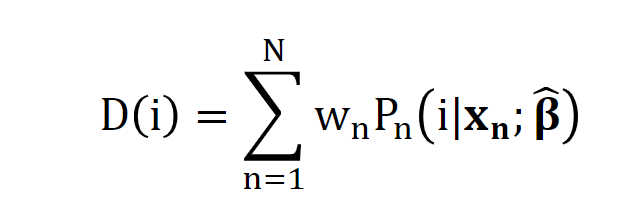

Market Share is Aggregate Demand (Formula Above) / sum of individual Weights

In [36]:
Sorted[0].groupby('mode_id').agg({'Prob * Weight': 'sum', 'weights': 'sum'}) #groupby check

,Prob * Weight,weights
mode_id,,
1,29860.197691,78044.5
2,10084.221976,84150.5
3,2143.738160,23509.0
4,1093.571109,22251.5
5,26199.534309,68747.0
6,14769.236755,75970.0


In [37]:
Shares1 = []
for copy in Sorted:
    A = copy.groupby('mode_id').agg({'Prob * Weight': 'sum', 'weights': 'sum'})
    A['Share']  = A['Prob * Weight'] / A['weights']
    Shares1.append(A)
Shares1[7] # Example market share for toll = $7 

,Prob * Weight,weights,Share
mode_id,,,
1,15330.666810,78044.5,0.196435
2,3092.296336,84150.5,0.036747
3,4609.009329,23509.0,0.196053
4,2258.768931,22251.5,0.101511
5,40092.055014,68747.0,0.583183
6,18767.703580,75970.0,0.247041


In [38]:
Marketarr = [] #matrix of market shares based on toll cost increases and mode_id
for shares in Shares1:
    Marketarr.append(shares['Share'])
df = pd.DataFrame(Marketarr)
ShareFrame = df.reset_index()
ShareFrame = ShareFrame.rename(columns={1:'Drive Alone',2:'Shared Ride',3:'Walk',4:'Bike',5:'Walk to Transit',6:'Drive to Transit'})
ShareFrame = ShareFrame.drop(columns=['index'])
ShareFrame.index.name = 'Toll Cost Increases $'
ShareFrame

mode_id,Drive Alone,Shared Ride,Walk,Bike,Walk to Transit,Drive to Transit
Toll Cost Increases $,,,,,,
0,0.382605,0.119836,0.091188,0.049146,0.381101,0.194409
1,0.312536,0.077902,0.146033,0.072840,0.471415,0.207201
2,0.276745,0.060145,0.168980,0.083044,0.512203,0.216639
3,0.254187,0.051143,0.177746,0.089086,0.535440,0.224273
4,0.234018,0.045090,0.184820,0.094267,0.554395,0.230839
5,0.217012,0.041283,0.190369,0.098304,0.568845,0.236551
6,0.205147,0.038469,0.194461,0.100493,0.577765,0.241877
7,0.196435,0.036747,0.196053,0.101511,0.583183,0.247041
8,0.188626,0.035369,0.196795,0.102271,0.587626,0.252117


In [39]:
import matplotlib.pyplot as plt
plt.rcdefaults()

from labellines import labelLine, labelLines

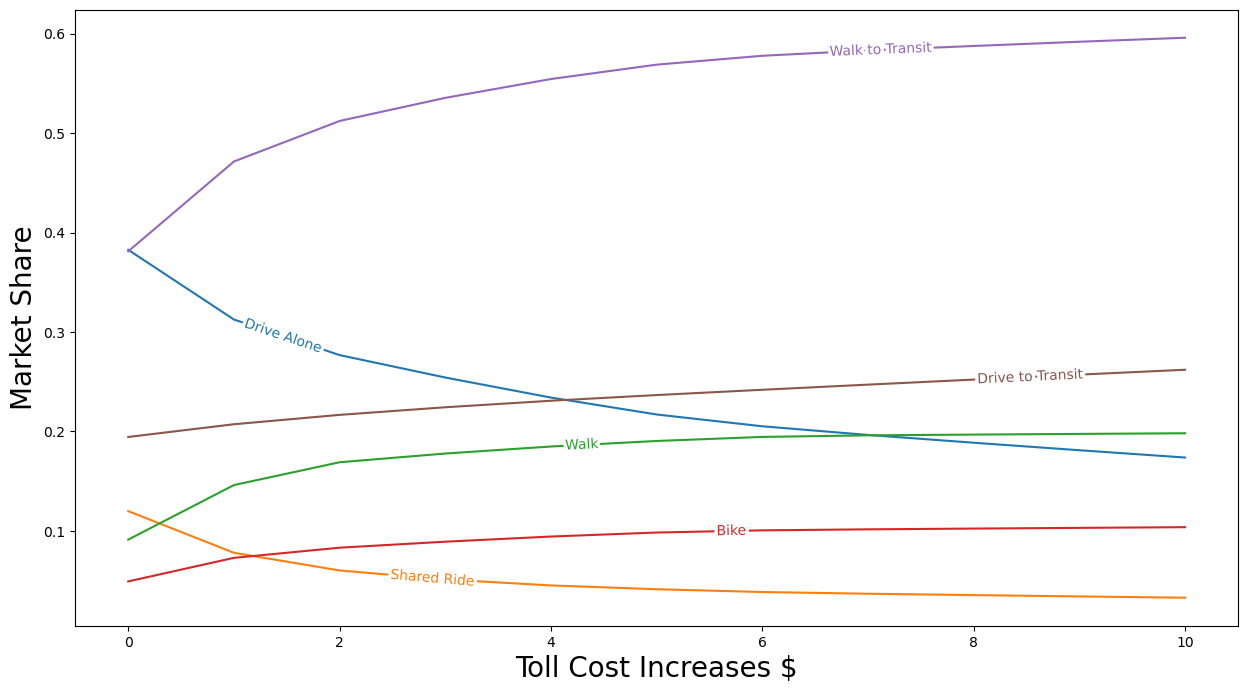

In [40]:
ax = ShareFrame.plot(figsize = (15,8))
ax.set_ylabel('Market Share', fontsize = 20)
ax.set_xlabel('Toll Cost Increases $', fontsize = 20)
labelLines(plt.gca().get_lines(), zorder=2.5)
ax.get_legend().remove()
plt.show()





# Greenhouse gas (GHG) emissions have become a very important decision variable of late. One of the consequences of the congestion toll will be a shift from driving to other more sustainable modes such as public transit and biking. To get a rough estimate of the impact, assume that a car on average emits 0.916 lbs. of CO2 per mile traveled. 

In [41]:
GHGFrames = Sorted.copy() #add a column measuring the pounds of CO2 emitted by the drive alone and shared ride option
for copy in GHGFrames:
    copy['CO2 lbs'] = copy['distance_car'] * .916
GHGFrames[0]

,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,initial_wait_hrs,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three,intercept,Probability,Prob * Weight,CO2 lbs
48,16,1,0,1005,2,123.0,96.39,27.98,6.5176,0.00,...,0.000000,0.000,0.000000,2.00,4.5176,-0.0000,1.0,0.274635,33.780125,25.62968
49,16,2,0,1005,2,123.0,96.39,27.98,3.2588,0.00,...,0.000000,0.000,0.000000,2.00,1.2588,-0.0000,1.0,0.098929,12.168265,25.62968
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.291667,0.125,0.416667,2.00,1.9900,-0.0000,1.0,0.109494,13.467790,0.00000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.125000,0.000,0.125000,2.00,1.8600,-0.0000,1.0,0.516942,63.583820,0.00000
122,34,1,0,1003,30,135.0,96.87,24.46,5.8965,0.00,...,0.000000,0.000,0.000000,2.00,3.8965,-0.0000,1.0,0.331102,44.698743,22.40536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.051500,0.000,0.051500,1.66,0.0000,-0.0000,1.0,0.784752,170.291176,0.00000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.056333,0.000,0.056333,2.00,1.2600,-0.0000,1.0,0.028816,6.253011,0.00000
37868,9988,1,0,952,24,207.0,125.49,35.14,7.7812,0.00,...,0.000000,0.000,0.000000,2.00,5.0000,0.7812,1.0,0.494150,102.289100,32.18824
37869,9988,2,1,952,24,207.0,125.49,35.14,3.8906,0.00,...,0.000000,0.000,0.000000,2.00,1.8906,-0.0000,1.0,0.179941,37.247734,32.18824


In [42]:
for copy in GHGFrames: #Corresponding weight similar to previous example of the CO2 emissions
    copy['CO2 lbs * Prob * Weight'] = copy['CO2 lbs'] * copy['Prob * Weight']
GHGFrames[0]


,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,transfer_wait_hrs,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three,intercept,Probability,Prob * Weight,CO2 lbs,CO2 lbs * Prob * Weight
48,16,1,0,1005,2,123.0,96.39,27.98,6.5176,0.00,...,0.000,0.000000,2.00,4.5176,-0.0000,1.0,0.274635,33.780125,25.62968,865.773799
49,16,2,0,1005,2,123.0,96.39,27.98,3.2588,0.00,...,0.000,0.000000,2.00,1.2588,-0.0000,1.0,0.098929,12.168265,25.62968,311.868728
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.125,0.416667,2.00,1.9900,-0.0000,1.0,0.109494,13.467790,0.00000,0.000000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.000,0.125000,2.00,1.8600,-0.0000,1.0,0.516942,63.583820,0.00000,0.000000
122,34,1,0,1003,30,135.0,96.87,24.46,5.8965,0.00,...,0.000,0.000000,2.00,3.8965,-0.0000,1.0,0.331102,44.698743,22.40536,1001.491429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.000,0.051500,1.66,0.0000,-0.0000,1.0,0.784752,170.291176,0.00000,0.000000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.000,0.056333,2.00,1.2600,-0.0000,1.0,0.028816,6.253011,0.00000,0.000000
37868,9988,1,0,952,24,207.0,125.49,35.14,7.7812,0.00,...,0.000,0.000000,2.00,5.0000,0.7812,1.0,0.494150,102.289100,32.18824,3292.506093
37869,9988,2,1,952,24,207.0,125.49,35.14,3.8906,0.00,...,0.000,0.000000,2.00,1.8906,-0.0000,1.0,0.179941,37.247734,32.18824,1198.938994


In [43]:
for GHG in GHGFrames:     #difference between GHG in each subsequent toll frame using base 0 $ toll as max
    GHG['Reduction'] = GHGFrames[0]['CO2 lbs * Prob * Weight'] - GHG['CO2 lbs * Prob * Weight']
GHGFrames[1]

,obsID,mode_id,choice,originTAZ,destTAZ,weights,travel_time,distance_car,travel_cost,access_time,...,initial_transfer_wait_hrs,cost_cat_one,cost_cat_two,cost_cat_three,intercept,Probability,Prob * Weight,CO2 lbs,CO2 lbs * Prob * Weight,Reduction
48,16,1,0,1005,2,123.0,96.39,27.98,7.5176,0.00,...,0.000000,2.00,5.0000,0.5176,1.0,0.243419,29.940586,25.62968,767.367631,98.406168
49,16,2,0,1005,2,123.0,96.39,27.98,4.2588,0.00,...,0.000000,2.00,2.2588,-0.0000,1.0,0.076730,9.437791,25.62968,241.887566,69.981162
50,16,5,0,1005,2,123.0,78.80,0.00,3.9900,28.40,...,0.416667,2.00,1.9900,-0.0000,1.0,0.118831,14.616157,0.00000,0.000000,0.000000
51,16,6,1,1005,2,123.0,42.80,0.00,3.8600,11.24,...,0.125000,2.00,1.8600,-0.0000,1.0,0.561020,69.005466,0.00000,0.000000,0.000000
122,34,1,0,1003,30,135.0,96.87,24.46,6.8965,0.00,...,0.000000,2.00,4.8965,-0.0000,1.0,0.270474,36.513935,22.40536,818.107864,183.383565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37760,9962,5,1,170,4,217.0,36.26,0.00,1.6600,9.00,...,0.051500,1.66,0.0000,-0.0000,1.0,0.837550,181.748308,0.00000,0.000000,0.000000
37761,9962,6,0,170,4,217.0,35.60,0.00,3.2600,13.55,...,0.056333,2.00,1.2600,-0.0000,1.0,0.030754,6.673711,0.00000,0.000000,0.000000
37868,9988,1,0,952,24,207.0,125.49,35.14,8.7812,0.00,...,0.000000,2.00,5.0000,1.7812,1.0,0.501379,103.785552,32.18824,3340.674268,-48.168175
37869,9988,2,1,952,24,207.0,125.49,35.14,4.8906,0.00,...,0.000000,2.00,2.8906,-0.0000,1.0,0.141079,29.203454,32.18824,940.007770,258.931224


In [44]:
GHGFrames[1].groupby('mode_id').agg({'Reduction': 'sum', 'CO2 lbs': 'sum'}) #groupby test

,Reduction,CO2 lbs
mode_id,,
1,39963.601165,27906.06824
2,51638.339090,28497.31876
3,0.000000,0.00000
4,0.000000,0.00000
5,0.000000,0.00000
6,0.000000,0.00000


In [45]:
Shares2 = []
for copy in GHGFrames:
    A = copy.groupby('mode_id').agg({'Reduction': 'sum', 'CO2 lbs': 'sum'})
    A['CO2 % Reduction']  = A['Reduction'] / (A['CO2 lbs'])
    Shares2.append(A)
Shares2[1]

,Reduction,CO2 lbs,CO2 % Reduction
mode_id,,,
1,39963.601165,27906.06824,1.432076
2,51638.339090,28497.31876,1.812042
3,0.000000,0.00000,NaN
4,0.000000,0.00000,NaN
5,0.000000,0.00000,NaN
6,0.000000,0.00000,NaN


In [46]:
Marketarr2 = [] #matrix for the co2 forecasts based on toll cost increases and mode_id
for shares in Shares2:
    Marketarr2.append(shares['CO2 % Reduction'])
df = pd.DataFrame(Marketarr2)
ShareFrame2 = df.reset_index()
ShareFrame2 = ShareFrame2.rename(columns={1:'Drive Alone',2:'Shared Ride',3:'Walk',4:'Bike',5:'Walk to Transit',6:'Drive to Transit'})
ShareFrame2 = ShareFrame2.drop(columns=['index'])
ShareFrame2.fillna(0, inplace=True) #Removes NaN CO2 market shares
ShareFrame2.index.name = 'Toll Cost Increases $'
ShareFrame2

mode_id,Drive Alone,Shared Ride,Walk,Bike,Walk to Transit,Drive to Transit
Toll Cost Increases $,,,,,,
0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1.432076,1.812042,0.0,0.0,0.0,0.0
2,2.488662,2.773804,0.0,0.0,0.0,0.0
3,3.438073,3.400955,0.0,0.0,0.0,0.0
4,4.405021,3.798500,0.0,0.0,0.0,0.0
5,5.321038,4.047751,0.0,0.0,0.0,0.0
6,6.119812,4.244444,0.0,0.0,0.0,0.0
7,6.865987,4.408658,0.0,0.0,0.0,0.0
8,7.592708,4.565708,0.0,0.0,0.0,0.0


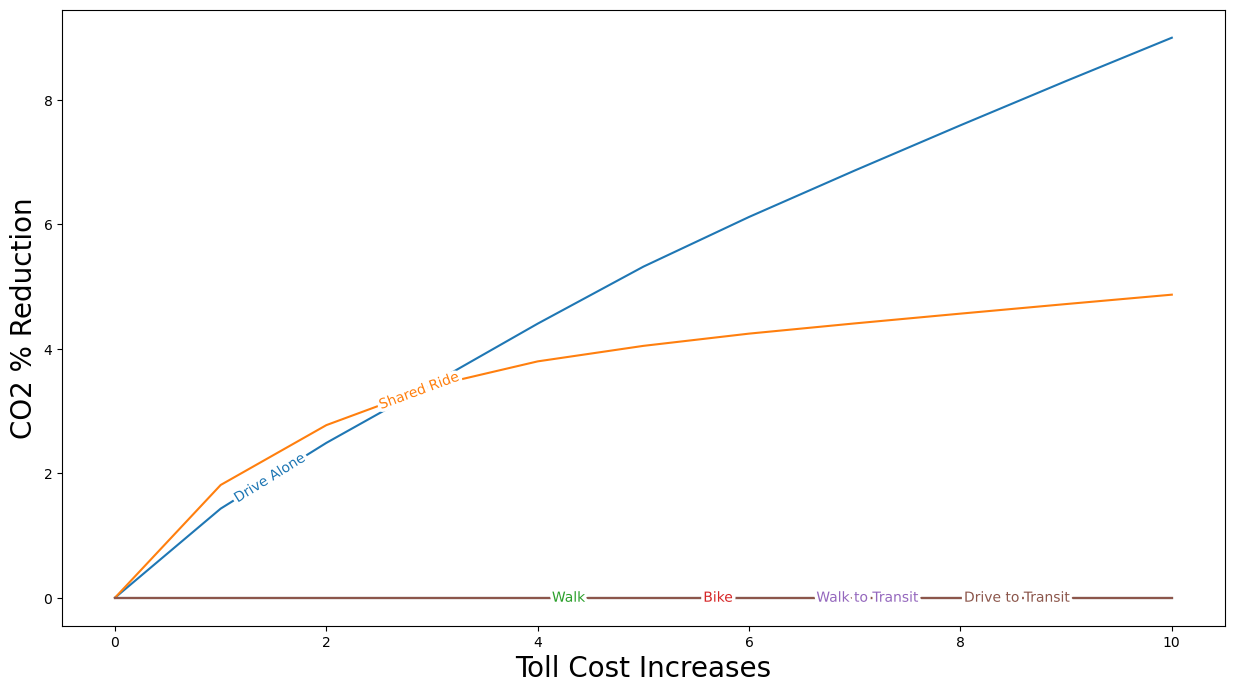

In [47]:
ax = ShareFrame2.plot(figsize = (15,8))
ax.set_ylabel('CO2 % Reduction', fontsize = 20)
ax.set_xlabel('Toll Cost Increases', fontsize = 20)
labelLines(plt.gca().get_lines(), zorder=2.5)
ax.get_legend().remove()
plt.show()

I was able to determine a reduction in CO2 emissions for a givin idividual by multiplying the CO2 lbs for a given distance driven. I then obtained the aggregate demand by multiplying by the Prob * Weight conducted earlier. The next step was to use the base no toll dataframe to realize what the reductions for the incremental tolls were. In detail this mean I would subtract the CO2 lbs* Prob * Weight for an x USD toll from the base CO2 lbs * Prob * Weight from the 0 USD toll to get the reduction. Using this reduction the final step was to then divided the reduction of each toll by the total emissions for that toll in order to get the percent reduction. The next steps were similar to problem 1 as the graph properly shows that as the toll cost increases the % reduction of CO2 also increases.

Travel Time should change as a result of congestion change, it might be increased for public transit because of the increased ridership that comes with increased market shares. Although travel time may decrease for the car riding options given there is less congestion on the road

My mode share and CO2 emission forecasts are most likely overestimates. For example one would assume there would be an increase in carpool rides. An inconsistency arises because the ratio of shared/solo driving decreases from around 30% to 18% which is nonsensical through the toll increments. There is too heavy a shift into public transit in this example. As for the CO2 emissions forecast I think these are accurate numbers given that the numbers for both shared rides and solo driving have parallel similarities 